# Decision Boundaries

In [10]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.qda import QDA
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from pandas import DataFrame, Index
from IPython.core.display import HTML

In [2]:
sdss = pd.read_hdf('data/sdss.h5', 'sdss')
feature_names = ["psfMag_u", "psfMag_g", "psfMag_r", "psfMag_i", "psfMag_z",
                 "petroMag_u", "petroMag_g", "petroMag_r", "petroMag_i", "petroMag_z", "petroRad_r"]
target_name = "class"

In [22]:
svm_clf = SVC(kernel='rbf', random_state=7, cache_size=2000, class_weight='auto', probability=True)
X_train, X_test, y_train, y_test = train_test_split(np.array(sdss[feature_names]), np.array(sdss[target_name]),
                                                    train_size=100000, test_size=100000, random_state=6)

In [23]:
svm_clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=2000, class_weight='auto', coef0=0.0, degree=3,
  gamma=0.0, kernel='rbf', max_iter=-1, probability=True, random_state=7,
  shrinking=True, tol=0.001, verbose=False)

In [24]:
y_pred = svm_clf.predict(X_test)
balanced_accuracy_expected(metrics.confusion_matrix(y_test, y_pred))

0.91537690932953386

In [28]:
thresholds_logistic = np.arange(0, 1, 0.02)
accuracies_logistic = []
percent_unknowns_logistic = []

# compute the probability from the linear predictor (returned by `decision_function`)
probabilities = svm_clf.predict_proba(X_test[:10000])

# take the max probability for each test sammple
max_probs = probabilities.max(axis=1)



In [29]:
for t in thresholds_logistic:
    # select only objects from test set where the likelihood from all classes is higher than threshold
    high_probabilities_index = probabilities.max(axis=1) > t
    percent_unknowns_logistic.append(sum(np.invert(high_probabilities_index)) / 10000)
    X_test_high = X_test[:10000][high_probabilities_index]
    y_test_high = y_test[:10000][high_probabilities_index]
    
    # with above selection, predict the class
    y_pred_test_high = svm_clf.predict(X_test_high)
    confusion_test_high = metrics.confusion_matrix(y_test_high, y_pred_test_high)
    accuracies_logistic.append(balanced_accuracy_expected(confusion_test_high))

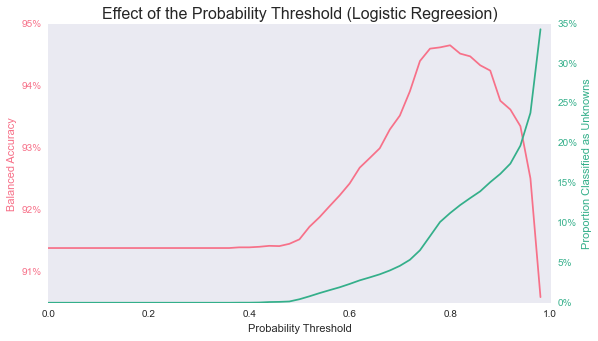

In [30]:
sns.set_style("dark")
fig, ax1 = plt.subplots(figsize=(9, 5))
colour1 = sns.color_palette()[0]
colour2 = sns.color_palette()[3]

ax1.plot(thresholds_logistic, accuracies_logistic, color=colour1)
ax1.set_xlabel('Probability Threshold')
ax1.set_title('Effect of the Probability Threshold (Logistic Regreesion)')
format_as_percent = lambda x, pos: "{:.0f}%".format(x * 100)
ax1.get_yaxis().set_major_formatter(FuncFormatter(format_as_percent))
ax1.set_ylabel('Balanced Accuracy', color=colour1)
for tl in ax1.get_yticklabels():
    tl.set_color(colour1)

ax2 = ax1.twinx()
ax2.plot(thresholds_logistic, percent_unknowns_logistic, color=colour2)
ax2.get_yaxis().set_major_formatter(FuncFormatter(format_as_percent))
ax2.set_ylabel('Proportion Classified as Unknowns', color=colour2)
for tl in ax2.get_yticklabels():
    tl.set_color(colour2)

plt.show()

## <a id='s5'></a> 5. Probablisitic Approach with QDA

A simple approach to classify unknown objects is to fit a Gaussian distribution to the features of each class. Then, given a test object, we can compute the likelihood function of each class. If the value of the likelihood is too low for all of the classes, we'd classify the object as an unknown. We'll investigate how varying the likelihood threshold will affect the accuracy rate and the number of identified unknowns.

In [253]:
train_size = 2000000
test_size = 30000
X_train, X_test, y_train, y_test = train_test_split(sdss[feature_names], sdss[target_name],
                                                    train_size=train_size, test_size=test_size, random_state=6)
clf_QDA = QDA()
clf_QDA.fit(X_train, y_train)

thresholds = np.arange(0, 30, 0.5)
accuracies_QDA = []
percent_unknowns = []

for t in thresholds:
    # `decision_function` computes the log (likelihood * prior)
    # exponentiate this to get the likelihood function
    likelihood = np.exp(clf_QDA.decision_function(X_test))
    
    # select only objects from test set where the likelihood from all classes is higher than threshold
    high_likelihood_index = likelihood.max(axis=1) > t
    percent_unknowns.append(sum(np.invert(high_likelihood_index)) / test_size)
    X_test_high = X_test[high_likelihood_index]
    y_test_high = y_test[high_likelihood_index]
    
    # with above selection, predict the class
    y_pred_test_high = clf_QDA.predict(X_test_high)
    confusion_test_high = metrics.confusion_matrix(y_test_high, y_pred_test_high)
    accuracies_QDA.append(balanced_accuracy_expected(confusion_test_high))

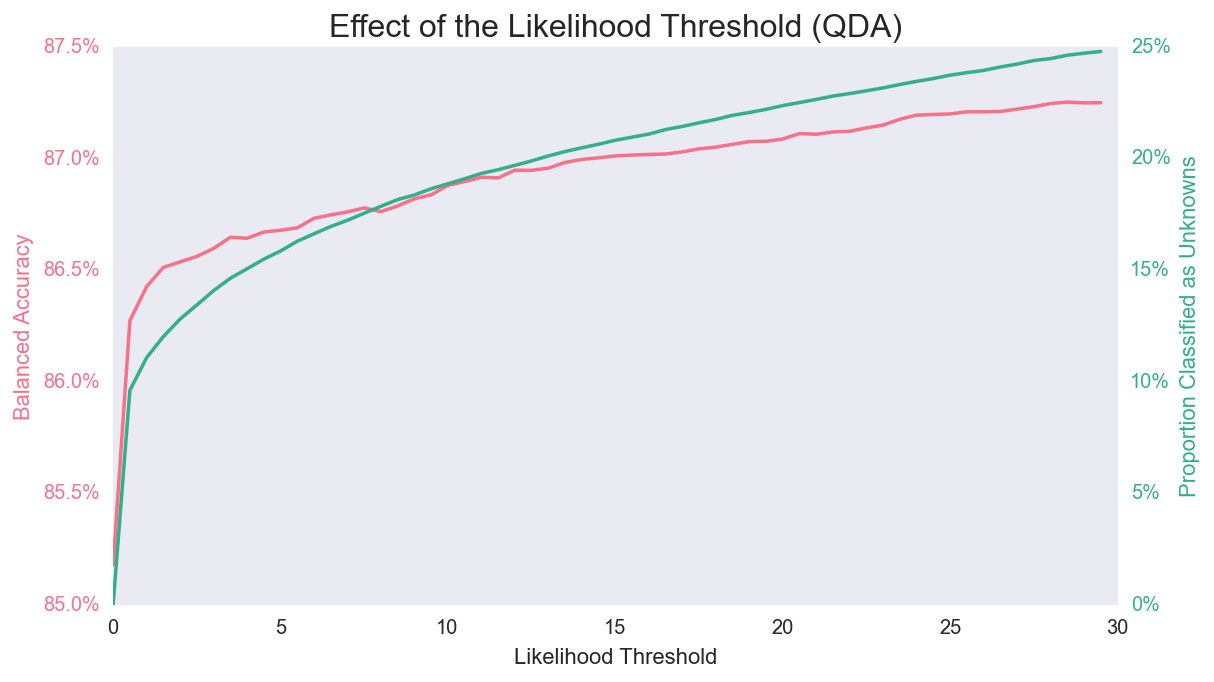

In [256]:
sns.set_style("dark")
fig, ax1 = plt.subplots(figsize=(9, 5))
colour1 = sns.color_palette()[0]
colour2 = sns.color_palette()[3]

ax1.plot(thresholds, accuracies_QDA, color=colour1)
ax1.set_xlabel('Likelihood Threshold')
ax1.set_title('Effect of the Likelihood Threshold (QDA)')
format_as_percent1 = lambda x, pos: "{:.1f}%".format(x * 100)
ax1.get_yaxis().set_major_formatter(FuncFormatter(format_as_percent1))
ax1.set_ylabel('Balanced Accuracy', color=colour1)
for tl in ax1.get_yticklabels():
    tl.set_color(colour1)

ax2 = ax1.twinx()
ax2.plot(thresholds, percent_unknowns, color=colour2)
format_as_percent2 = lambda x, pos: "{:.0f}%".format(x * 100)
ax2.get_yaxis().set_major_formatter(FuncFormatter(format_as_percent2))
ax2.set_ylabel('Proportion Classified as Unknowns', color=colour2)
for tl in ax2.get_yticklabels():
    tl.set_color(colour2)

plt.show()

## <a id='s6'></a> 6. Probabilistic Approach with One-vs-Rest Logistic Regression

The one-vs-rest logistic regression in `scikit-learn` can compute the linear predictor $\eta_i$ by calling `decision_function()`. From this we can calculate the probability $p_i$ of being in class $i$ by using the sigmoid function:
    \begin{aligned}
    p_i = \dfrac{1}{1 + e^{-\eta_i}}
    \end{aligned}

Again, let's see how changing the cut-off probability affect the accuracy rate and the number of unknowns identified in the test set.

In [4]:
train_size = 2000000
test_size = 30000
X_train, X_test, y_train, y_test = train_test_split(sdss[feature_names], sdss[target_name],
                                                    train_size=train_size, test_size=test_size, random_state=6)
clf_logistic = LogisticRegression(random_state=2)
clf_logistic.fit(X_train, y_train)

thresholds_logistic = np.arange(0, 1, 0.02)
accuracies_logistic = []
percent_unknowns_logistic = []

# compute the probability from the linear predictor (returned by `decision_function`)
probabilities = clf_logistic.decision_function(X_test)
probabilities *= -1
np.exp(probabilities, probabilities)
probabilities += 1
np.reciprocal(probabilities, probabilities)

# take the max probability for each test sammple
max_probs = probabilities.max(axis=1)

for t in thresholds_logistic:
    # select only objects from test set where the likelihood from all classes is higher than threshold
    high_probabilities_index = probabilities.max(axis=1) > t
    percent_unknowns_logistic.append(sum(np.invert(high_probabilities_index)) / test_size)
    X_test_high = X_test[high_probabilities_index]
    y_test_high = y_test[high_probabilities_index]
    
    # with above selection, predict the class
    y_pred_test_high = clf_logistic.predict(X_test_high)
    confusion_test_high = metrics.confusion_matrix(y_test_high, y_pred_test_high)
    accuracies_logistic.append(balanced_accuracy_expected(confusion_test_high))

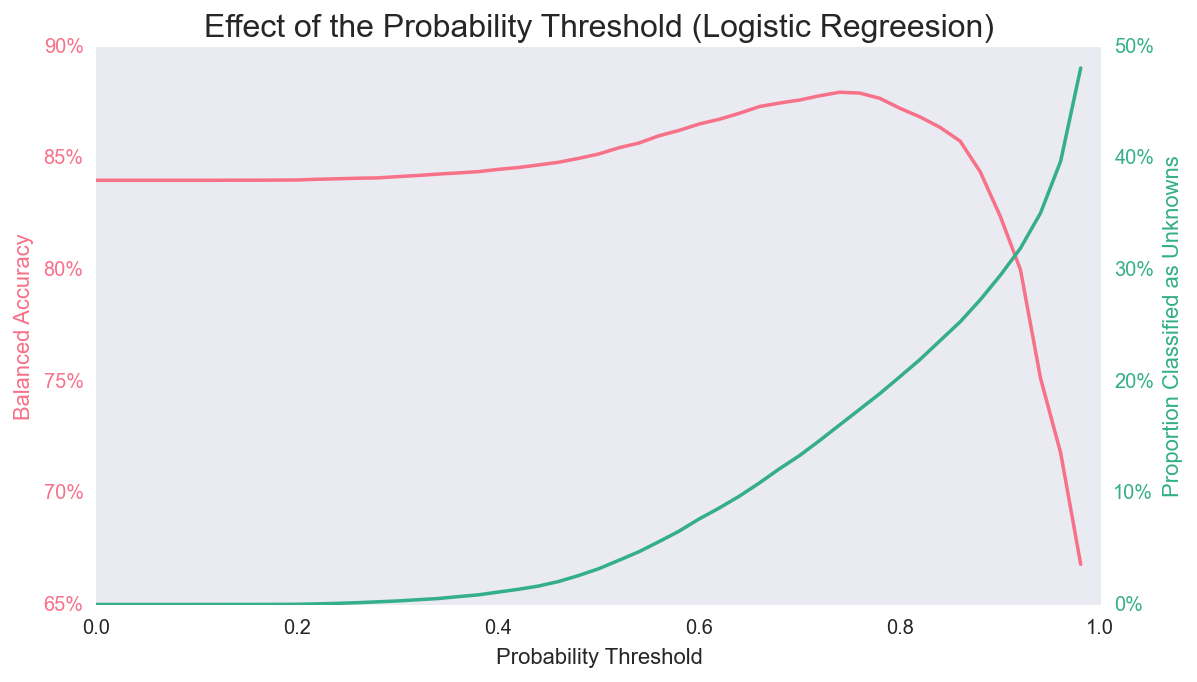

In [5]:
sns.set_style("dark")
fig, ax1 = plt.subplots(figsize=(9, 5))
colour1 = sns.color_palette()[0]
colour2 = sns.color_palette()[3]

ax1.plot(thresholds_logistic, accuracies_logistic, color=colour1)
ax1.set_xlabel('Probability Threshold')
ax1.set_title('Effect of the Probability Threshold (Logistic Regreesion)')
format_as_percent = lambda x, pos: "{:.0f}%".format(x * 100)
ax1.get_yaxis().set_major_formatter(FuncFormatter(format_as_percent))
ax1.set_ylabel('Balanced Accuracy', color=colour1)
for tl in ax1.get_yticklabels():
    tl.set_color(colour1)

ax2 = ax1.twinx()
ax2.plot(thresholds_logistic, percent_unknowns_logistic, color=colour2)
ax2.get_yaxis().set_major_formatter(FuncFormatter(format_as_percent))
ax2.set_ylabel('Proportion Classified as Unknowns', color=colour2)
for tl in ax2.get_yticklabels():
    tl.set_color(colour2)

plt.show()

It's very strange how the accuracy actually goes down as we increase the probability threshold. Let's investigate this by binning the results into 10 bins.

In [ ]:
sorted_test = DataFrame(np.concatenate((X_test, y_test[np.newaxis].T, max_probs[np.newaxis].T), axis=1)).sort(12)
no_bins = 10
bin_size = int(len(sorted_test) / no_bins)
X_test_bins, y_test_bins, probs_bin, percent_unknowns_logistics, accuracies_logistics  = [], [], [], [], []
thresholds_logistic = np.arange(0, 1, 0.02)

for b in range(no_bins):
    X_test_bins.append(np.array(sorted_test[b * bin_size:b * bin_size + bin_size][[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]).astype(float))
    y_test_bins.append(np.array(sorted_test[b * bin_size:b * bin_size + bin_size][[11]]))
    probs_bin.append(np.array(sorted_test[b * bin_size:b * bin_size + bin_size][[12]]).astype(float))
    
    percent_unknowns_logistic = []
    accuracies_logistic = []
    for t in thresholds_logistic:
        # select only objects from test set where the likelihood from all classes is higher than threshold
        high_probabilities_index = probs_bin[b] > t
        high_probabilities_index = high_probabilities_index.T[0]
        percent_unknowns_logistic.append(sum(np.invert(high_probabilities_index)) / bin_size)
        X_test_high = X_test_bins[b][high_probabilities_index]
        y_test_high = y_test_bins[b][high_probabilities_index]

        # with above selection, predict the class
        y_pred_test_high = clf_logistic.predict(X_test_high)
        confusion_test_high = metrics.confusion_matrix(y_test_high, y_pred_test_high)
        accuracies_logistic.append(balanced_accuracy_expected(confusion_test_high))
        
    percent_unknowns_logistics.append(percent_unknowns_logistic)
    accuracies_logistics.append(accuracies_logistic)

In [ ]:
sns.set_style("dark")
fig, ax1 = plt.subplots(figsize=(9, 5))
ax2 = ax1.twinx()
colour1 = sns.color_palette()[0]
colour2 = sns.color_palette()[3]

for a, p in zip(accuracies_logistics, percent_unknowns_logistics):
    ax1.plot(thresholds_logistic, a, color=colour1)
    ax2.plot(thresholds_logistic, p, color=colour2)
    
ax1.set_xlabel('Probability Threshold')
ax1.set_title('Effect of the Probability Threshold (Logistic Regreesion)')
format_as_percent = lambda x, pos: "{:.0f}%".format(x * 100)
ax1.get_yaxis().set_major_formatter(FuncFormatter(format_as_percent))
ax1.set_ylabel('Balanced Accuracy', color=colour1)
for tl in ax1.get_yticklabels():
    tl.set_color(colour1)



ax2.get_yaxis().set_major_formatter(FuncFormatter(format_as_percent))
ax2.set_ylabel('Proportion Classified as Unknowns', color=colour2)
for tl in ax2.get_yticklabels():
    tl.set_color(colour2)

plt.show()